In [1]:
#import relevant library

import math
import os
import random
import pickle
import argparse
from collections import deque
import time
from datetime import timedelta
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
# from torchvision import transforms
from torch.utils.data import IterableDataset, DataLoader, get_worker_info
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
model1 = (torch.load('models/01_pytorch_workflow_model_1.pth'))
list(model1.items())[1][1].size()

torch.Size([3760, 64])

In [84]:
u = list(model1.items())[0][1][674]
i = list(model1.items())[1][1]

In [85]:
x_ui = torch.mul(u, i).sum(dim=1)
x_ui

tensor([-0.0013, -0.0167, -0.0044,  ..., -0.0014, -0.0121, -0.0030])

In [86]:
perturbation = torch.rand(1)

In [87]:
x_ui+perturbation


tensor([0.6118, 0.5964, 0.6087,  ..., 0.6117, 0.6010, 0.6101])

In [94]:
torch.sigmoid(x_ui+perturbation)

tensor([0.6483, 0.6448, 0.6476,  ..., 0.6483, 0.6459, 0.6480])

In [90]:
with open('preprocessed/ml-1m.pickle', 'rb') as f:
    dataset = pickle.load(f)
    user_size, item_size = dataset['user_size'], dataset['item_size']
    train_user_list, test_user_list = dataset['train_user_list'], dataset['test_user_list']
    train_pair = dataset['train_pair']

In [92]:
dataset['train_pair']

[(0, 32),
 (0, 34),
 (0, 4),
 (0, 35),
 (0, 30),
 (0, 29),
 (0, 33),
 (0, 40),
 (0, 10),
 (0, 16),
 (0, 23),
 (0, 28),
 (0, 12),
 (0, 8),
 (0, 5),
 (0, 20),
 (0, 46),
 (0, 15),
 (0, 50),
 (0, 49),
 (0, 13),
 (0, 1),
 (0, 52),
 (0, 38),
 (0, 19),
 (0, 6),
 (0, 2),
 (0, 26),
 (0, 17),
 (0, 39),
 (0, 45),
 (0, 42),
 (0, 14),
 (0, 11),
 (0, 18),
 (0, 48),
 (0, 41),
 (0, 43),
 (0, 51),
 (0, 9),
 (0, 44),
 (0, 21),
 (0, 0),
 (0, 47),
 (0, 7),
 (0, 3),
 (0, 36),
 (0, 24),
 (0, 22),
 (0, 37),
 (0, 27),
 (0, 31),
 (1, 86),
 (1, 66),
 (1, 72),
 (1, 130),
 (1, 73),
 (1, 79),
 (1, 126),
 (1, 163),
 (1, 91),
 (1, 98),
 (1, 60),
 (1, 137),
 (1, 107),
 (1, 118),
 (1, 154),
 (1, 146),
 (1, 69),
 (1, 74),
 (1, 83),
 (1, 160),
 (1, 157),
 (1, 94),
 (1, 65),
 (1, 125),
 (1, 119),
 (1, 58),
 (1, 122),
 (1, 117),
 (1, 93),
 (1, 120),
 (1, 166),
 (1, 150),
 (1, 155),
 (1, 90),
 (1, 145),
 (1, 110),
 (1, 78),
 (1, 113),
 (1, 62),
 (1, 156),
 (1, 148),
 (1, 144),
 (1, 97),
 (1, 48),
 (1, 151),
 (1, 132),
 (1,

In [ ]:
class Adversary(torch.nn.Module):
    def __init__(self, input_dim, output_dim, with_y=False, with_logits=False, use_mlp=False, with_logits_y=False,
                 with_single_y=False):
        super(Adversary4Z, self).__init__() #inherit properties
        self.c = torch.nn.Parameter(torch.tensor(1.0, requires_grad=True)) #initialize parameters to optimize for
        self.input_dim = input_dim #number of labels
        self.with_y = with_y #number of groups
        self.with_logits = with_logits 
        self.with_logits_y = with_logits_y
        self.with_single_y = with_single_y

        # the basic input = [s], to determine which defition of fairness we are going with
        if self.with_logits:  # input = concat([input, logits])
            self.input_dim += input_dim
        if self.with_y:  # input = concat([input, s*y, s*(1-y)])
            self.input_dim += input_dim * 2
        if self.with_logits_y:  # input = concat([input, logits*y, logits*(1-y)])
            self.input_dim += input_dim * 2
        if self.with_single_y:  # input = concat([input, y])
            self.input_dim += 1

        self.use_mlp = use_mlp
        # basically its a mlp that predict group from input dimension
        if self.use_mlp:
            hidden_dim = [128, 128]
            hidden_dim = [self.input_dim] + list(hidden_dim) + [output_dim]
            self.seq = torch.nn.ModuleList() #this is just like a python list but an instance of submodule
            for i in range(1, len(hidden_dim)):
                self.seq.append(torch.nn.Linear(hidden_dim[i - 1], hidden_dim[i]))
                if i != (len(hidden_dim) - 1):
                    self.seq.append(torch.nn.ReLU())
        else:
            self.fc = torch.nn.Linear(self.input_dim, output_dim, bias=True)
            
    # Forward defines the computation in the model
    def forward(self, inputs, *, y=None):
        assert len(inputs.shape) == 2 #test if shape of input is 2 else raise assertion error

        #define for binary -- use sigmoid and multiclass -- use softmax adversary
        if inputs.shape[1] > 1:
            s = torch.softmax(inputs * (1 + torch.abs(self.c)), dim=-1)
            if self.with_y or self.with_logits_y or self.with_single_y:
                raise NotImplementedError  # only support binary case with y
        else:
            s = torch.sigmoid(inputs * (1 + torch.abs(self.c)))

        if self.with_y:
            assert y is not None #if adversary test with y then there must be an available value for y
            _y = y.view(-1, 1).long() # -1 is infered from other dim, if dim = n x n then view (-1,1) transform to n x 1
            assert len(_y) == inputs.shape[0] #size of y must be compatible with the input
            encoded_inputs = torch.cat([s, s * _y, s * (1 - _y)], dim=1)
        else:
            assert y is None
            encoded_inputs = s

        if self.with_logits:
            encoded_inputs = torch.cat([encoded_inputs, inputs], dim=1)

        if self.with_logits_y:
            assert y is not None
            _y = y.view(-1, 1).long()
            assert len(_y) == inputs.shape[0]
            encoded_inputs = torch.cat([encoded_inputs, inputs * _y, inputs * (1 - _y)], dim=1)

        if self.with_single_y:
            assert y is not None
            _y = y.view(-1, 1).long()
            assert len(_y) == inputs.shape[0]
            encoded_inputs = torch.cat([encoded_inputs, _y], dim=1)

        if self.use_mlp:
            logits = encoded_inputs
            for i, l in enumerate(self.seq):
                logits = l(logits)
        else:
            logits = self.fc(encoded_inputs)

        return logits


In [ ]:
adv = Adversary(input_dim=1, output_dim =6,use_mlp=True)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(adv.parameters(), lr=1e-3)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [ ]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

test_df = pd.read_csv('Data/train_df.csv', sep=',', encoding="utf-8",engine='python',header =None)
test_df = test_df.iloc[:, [3, 5, 6]]

X = torch.tensor(np.array(test_df.iloc[:,[0,2]])).type(torch.float)
Y = torch.tensor(test_df.iloc[:,1].astype('category').cat.codes).type(torch.LongTensor)   


X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X,
    Y,
    test_size=0.2,
    random_state=181
)

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    adv.train()

    # 1. Forward pass
    y_logits = adv(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    adv.eval()
    with torch.inference_mode():
      # 1. Forward pass
        test_logits = adv(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

In [64]:
def get_time_dif(start_time):
    """get the running time"""
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))

In [54]:
## set up the u,i,j triplet for BPR framework
class GetTriplePair(IterableDataset):
    # for ml-1m we load in 3760 item 6040 user and 994169 train pair
    def __init__(self, item_size, user_list, pair, shuffle, num_epochs):
        self.item_size = item_size
        self.user_list = user_list
        self.pair = pair
        self.shuffle = shuffle
        self.num_epochs = num_epochs

    def __iter__(self):
        self.example_size = self.num_epochs * len(self.pair)
        self.example_index_queue = deque([])
        self.seed = 0
        self.start_list_index = None
        self.num_workers = 1
        self.index = 0
        return self

    def __next__(self):
        if self.index >= self.example_size:
            raise StopIteration
        # If `example_index_queue` is used up, replenish this list.
        while len(self.example_index_queue) == 0:
            index_list = list(range(len(self.pair)))
            if self.shuffle:
                random.Random(self.seed).shuffle(index_list)
                self.seed += 1
            if self.start_list_index is not None:
                index_list = index_list[self.start_list_index::self.num_workers]

                # Calculate next start index
                self.start_list_index = (self.start_list_index + (self.num_workers - (len(self.pair) % self.num_workers))) % self.num_workers
            self.example_index_queue.extend(index_list)
        result = self._example(self.example_index_queue.popleft())
        self.index += self.num_workers
        return result

    def _example(self, idx):
        # in a train pair, format = (u,i), j = a random item which does not exist in user u's list of items
        u = self.pair[idx][0]
        i = self.pair[idx][1]
        j = np.random.randint(self.item_size)
        while j in self.user_list[u]:
            j = np.random.randint(self.item_size)
        return u, i, j

In [55]:
class MF(nn.Module):
    def __init__(self, user_size, item_size, dim, reg, reg_adv, eps):
        super().__init__()
        ##init the embedding for U and I
        self.W = nn.Parameter(torch.empty(user_size, dim))  # User embedding
        self.H = nn.Parameter(torch.empty(item_size, dim))  # Item embedding
        nn.init.xavier_normal_(self.W.data)
        nn.init.xavier_normal_(self.H.data)
        self.reg = reg
        self.user_size = user_size
        self.item_size = item_size
        self.dim = dim
        self.reg_adv = reg_adv
        self.eps = eps
        self.update_u = None
        self.update_i = None
        self.update_j = None

## forward cal
    def forward(self, u, i, j, epoch):
        """Return loss value.

        Args:
            u(torch.LongTensor): tensor stored user indexes. [batch_size,]
            i(torch.LongTensor): tensor stored item indexes which is prefered by user. [batch_size,]
            j(torch.LongTensor): tensor stored item indexes which is not prefered by user. [batch_size,]
            epoch

        Returns:
            torch.FloatTensor
        """
        ##u,i,j respectively, each is a vector of dim embedding (default = 64)
        u = self.W[u, :]
        i = self.H[i, :]
        j = self.H[j, :]

        ## Enables this Tensor to have their grad populated during backward(), convert any non-leaf tensor into a leaf tensor,
        ##https://stackoverflow.com/questions/73698041/how-retain-grad-in-pytorch-works-i-found-its-position-changes-the-grad-result
        u.retain_grad()
        u_clone = u.data.clone()
        i.retain_grad()
        i_clone = i.data.clone()
        j.retain_grad()
        j_clone = j.data.clone()

        ## mf, dot product of user with pos/neg item
        x_ui = torch.mul(u, i).sum(dim=1)
        x_uj = torch.mul(u, j).sum(dim=1)


        #similar to clip value, find diff between ui and uj
        x_uij =torch.clamp(x_ui - x_uj,min=-80.0,max=1e8)
        #logsigmoid this is equivalent to equation 1 in the paper (classic loss of bpr)
        log_prob = F.logsigmoid(x_uij).sum()
        # regularization = lambda * l2 norm of u, i, j
        regularization = self.reg * (u.norm(dim=1).pow(2).sum() + i.norm(dim=1).pow(2).sum() + j.norm(dim=1).pow(2).sum())

        ## original bpr loss,
        loss = -log_prob + regularization

        loss.backward()
        return loss
        # add adv training after a certain number of epochs, here is the part which we add hypernet module
        if epoch not in range(args.epochs, args.adv_epoch + args.epochs):
            """Normal training"""
            loss.backward()
            return loss

        else:
            """Adversarial training:
                    1.Backward to get grads
                    2.Construct adversarial perturbation
                    3.Add adversarial perturbation to embeddings
                    4.Calculate APR loss
            """
            # Backward to get grads
            # this would be the part we change in defining delta, delta = HPN (phi)

            # should we calculate based on gradient of the adv_loss instead of the loss function?, originally, computed based on loss function
            loss.backward(retain_graph=True) ## need to retain graph here so as to we can backprop the adv_loss
            ##recheck this
            grad_u = u.grad
            grad_i = i.grad
            grad_j = j.grad

            # Construct adversarial perturbation based on gradient of loss function, and normalize it with epsilon * norm
            if grad_u is not None:
                delta_u = nn.functional.normalize(grad_u, p=2, dim=1, eps=self.eps)
            else:
                delta_u = torch.rand(u.size())
            if grad_i is not None:
                delta_i = nn.functional.normalize(grad_i, p=2, dim=1, eps=self.eps)
            else:
                delta_i = torch.rand(i.size())
            if grad_j is not None:
                delta_j = nn.functional.normalize(grad_j, p=2, dim=1, eps=self.eps)
            else:
                delta_j = torch.rand(j.size())

            # Add adversarial perturbation to embeddings, now we have q+delta, p+delta
            x_ui_adv = torch.mul(u + delta_u, i + delta_i).sum(dim=1)
            x_uj_adv = torch.mul(u + delta_u, j + delta_j).sum(dim=1)

            # find difference between pos and neg item, then clip value
            x_uij_adv = torch.clamp(x_ui_adv - x_uj_adv,min=-80.0,max=1e8)

            # Calculate APR loss with logsigmoid
            log_prob = F.logsigmoid(x_uij_adv).sum()
            adv_loss = self.reg_adv *(-log_prob) + loss # this is adversarial loss (equation 4 in paper)
            adv_loss.backward()

            return adv_loss

## similar set of with batch size = 512
def evaluate_k(user_emb, item_emb, train_user_list, test_user_list, klist, batch=512):
    """Compute HR and NDCG at k.

    Args:
        user_emb (torch.Tensor): embedding for user [user_num, dim]
        item_emb (torch.Tensor): embedding for item [item_num, dim]
        train_user_list (list(set)):
        test_user_list (list(set)):
        k (list(int)):
    Returns:
        (torch.Tensor, torch.Tensor) HR and NDCG at k
    """

    # Calculate max k value
    max_k = max(klist)
    result = None

    # no iteration = user_num / batch size (which is 512)
    for i in range(0, user_emb.shape[0], batch):

        # Construct mask for each batch

        #new_ones returns a Tensor of size size filled with 1

        # size of the mask vector = (min of batch or user embed) * item+embed
        mask = user_emb.new_ones([min([batch, user_emb.shape[0]-i]), item_emb.shape[0]])
        for j in range(batch):
            if i+j >= user_emb.shape[0]:
                break
            mask[j].scatter_(dim=0, index=torch.tensor(list(train_user_list[i + j])), value=torch.tensor(0.0))

        # Get current result
        cur_result = torch.mm(user_emb[i:i+min(batch, user_emb.shape[0]-i), :], item_emb.t())
        cur_result = torch.sigmoid(cur_result)
        assert not torch.any(torch.isnan(cur_result))

        # Make zero for already observed item
        cur_result = torch.mul(mask, cur_result)
        _, cur_result = torch.topk(cur_result, k=max_k, dim=1)
        result = cur_result if result is None else torch.cat((result, cur_result), dim=0)


    ## basically this chunk collects the results
    result = result.cpu()

    # Sort indice and get HR_NDCG_topk
    HRs, NDCGs = [], []
    for k in klist:
        ndcg, hr = 0, 0
        for i in range(user_emb.shape[0]):
            test = set(test_user_list[i])
            pred = set(result[i, :k].numpy().tolist())
            val = len(test & pred)
            hr += val / max([len(test), 1])
            pred = list(pred)
            x = int(test_user_list[i][0])
            if pred.count(x) != 0:
                position = pred.index(x)
                ndcg += math.log(2) / math.log(position + 2) if position < k else 0
            else:
                ndcg += 0
        NDCGs.append(ndcg / user_emb.shape[0])
        HRs.append(hr / user_emb.shape[0])
        NDCGs.append(ndcg / user_emb.shape[0])
    return HRs, NDCGs

In [65]:
np.random.seed(181)
torch.manual_seed(181)
with open('preprocessed/ml-1m.pickle', 'rb') as f:
    dataset = pickle.load(f)
    user_size, item_size = dataset['user_size'], dataset['item_size']
    train_user_list, test_user_list = dataset['train_user_list'], dataset['test_user_list']
    train_pair = dataset['train_pair']
# Create dataset, model, optimizer
dataset = GetTriplePair(item_size, train_user_list, train_pair, True, 1000)
# load batch of 512 item triplets
loader = DataLoader(dataset, batch_size=512)
model = MF(user_size, item_size, 64, 0, 1, 0.5)
#this only optimize wrt embeddings, no delta included like the original paper?
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Training
start_time = time.time()
eval_best_loss = float('inf')
##zero_grad: zeroes the grad attribute of all the parameters passed to the optimizer upon construction
optimizer.zero_grad()
epoch = 0
HR_history = []
NDCG_history = []
#loader has batch size of 512. In each batch there are 3 tensors of u i j accordingly
for u, i, j in loader:
    if epoch in range(1000 + 0):
        loss = model(u, i, j, epoch)
        ##  updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.
        optimizer.step()
        HR_list, NDCG_list = evaluate_k(model.W.detach(),
                                                           model.H.detach(),
                                                           train_user_list,
                                                           test_user_list,
                                                           klist=[50, 100])
        if epoch % 20 == (20 - 1):
            if epoch in range(1000):
                print('BPR-MF Epoch [{}/{}]'.format(epoch + 1, 1000 + 0))
            if epoch in range(1000, 0 + 1000):
                print('AMF Epoch [{}/{}]'.format(epoch + 1, 1000 + 0))
            print('loss: %.4f' % loss)
            print('HR@50: %.4f, HR@100: %.4f, NDCG@50: %.4f, NDCG@100: %.4f' % (
                HR_list[0], HR_list[1], NDCG_list[0], NDCG_list[1]))
        HR_history.append(HR_list[1])
        NDCG_history.append(NDCG_list[1])
        if epoch % 100 == 0:
            if loss < eval_best_loss:
                eval_best_loss = loss
                dirname = os.path.dirname(os.path.abspath('output/bpr.bt'))
                os.makedirs(dirname, exist_ok=True)
                torch.save(model.state_dict(), 'output/bpr.bt')
                time_dif = get_time_dif(start_time)
                print("time", time_dif)
        epoch += 1
    else:
        break

time 0:00:02
BPR-MF Epoch [20/1000]
loss: 354.8182
HR@50: 0.0129, HR@100: 0.0235, NDCG@50: 0.0036, NDCG@100: 0.0036
BPR-MF Epoch [40/1000]
loss: 354.9321
HR@50: 0.0131, HR@100: 0.0258, NDCG@50: 0.0036, NDCG@100: 0.0036
BPR-MF Epoch [60/1000]
loss: 354.8322
HR@50: 0.0126, HR@100: 0.0267, NDCG@50: 0.0033, NDCG@100: 0.0033
BPR-MF Epoch [80/1000]
loss: 354.7670
HR@50: 0.0144, HR@100: 0.0270, NDCG@50: 0.0037, NDCG@100: 0.0037
BPR-MF Epoch [100/1000]
loss: 354.8853
HR@50: 0.0142, HR@100: 0.0276, NDCG@50: 0.0037, NDCG@100: 0.0037
BPR-MF Epoch [120/1000]
loss: 354.9158
HR@50: 0.0147, HR@100: 0.0308, NDCG@50: 0.0039, NDCG@100: 0.0039
BPR-MF Epoch [140/1000]
loss: 354.8450
HR@50: 0.0151, HR@100: 0.0288, NDCG@50: 0.0040, NDCG@100: 0.0040
BPR-MF Epoch [160/1000]
loss: 354.8035
HR@50: 0.0154, HR@100: 0.0283, NDCG@50: 0.0040, NDCG@100: 0.0040
BPR-MF Epoch [180/1000]
loss: 354.8709
HR@50: 0.0157, HR@100: 0.0329, NDCG@50: 0.0040, NDCG@100: 0.0040
BPR-MF Epoch [200/1000]
loss: 354.8224
HR@50: 0.0159, H

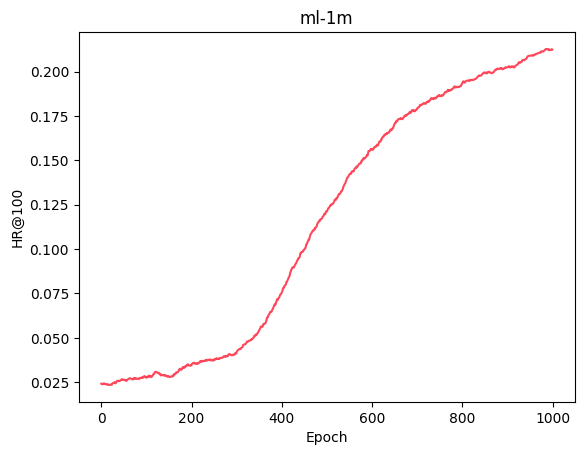

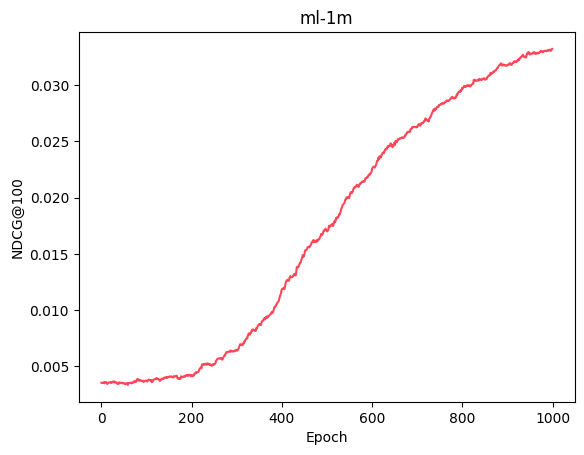

In [68]:
fig_HR = plt.figure(edgecolor='blue')
ax1 = fig_HR.add_subplot(111)
plt.ylabel('HR@100')
plt.xlabel('Epoch')
plt.title('ml-1m')
ax1.plot(range(len(HR_history)), HR_history, c=np.array([255, 71, 90]) / 255.)
plt.show()
fig_P = plt.figure(edgecolor='blue')
ax1 = fig_P.add_subplot(111)
plt.ylabel('NDCG@100')
plt.xlabel('Epoch')
plt.title('ml-1m')
ax1.plot(range(len(NDCG_history)), NDCG_history, c=np.array([255, 71, 90]) / 255.)
plt.show()